In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

#### Load the data

In [3]:
df = pd.read_csv('bank-full.csv',sep = ';')

In [4]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [6]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [7]:
# Select only the desired columns
selected_columns = [
    'age',
    'job',
    'marital',
    'education',
    'balance',
    'housing',
    'contact',
    'day',
    'month',
    'duration',
    'campaign',
    'pdays',
    'previous',
    'poutcome',
    'y'
]

In [8]:
df_selected = df[selected_columns]

In [9]:
df_selected.loc[:, 'y'] = (df_selected['y'] == 'yes').astype(int)

In [10]:
df_full_train, df_test = train_test_split(df_selected, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [11]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [12]:
y_train = df_train['y'].values
y_val = df_val['y'].values
y_test = df_test['y'].values

In [13]:
y_train , y_val , y_test

(array([0, 0, 0, ..., 0, 0, 0], dtype=object),
 array([0, 0, 0, ..., 0, 0, 0], dtype=object),
 array([0, 0, 0, ..., 0, 0, 1], dtype=object))

In [14]:
y_train = y_train.astype(int)
y_val = y_val.astype(int)
y_test = y_test.astype(int)

In [15]:
y_train , y_val , y_test

(array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 1]))

In [16]:
del df_train['y']
del df_val['y']
del df_test['y']

In [17]:
numerical_columns = list(df_train.dtypes[df_train.dtypes == 'int64'].index)
categorical_columns = list(df_train.dtypes[df_train.dtypes == 'object'].index)

In [18]:
dv = DictVectorizer(sparse=False)
train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

In [19]:
val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

### Question 1

In [20]:
numerical_columns

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [21]:
from sklearn.metrics import roc_auc_score
auc_scores = {}

for col in numerical_columns:
    auc = roc_auc_score(y_train, df_train[col])
    
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col])
    
    auc_scores[col] = auc

In [22]:
# Determine the variable with the highest AUC
highest_auc_col = max(auc_scores, key=auc_scores.get)
highest_auc_value = auc_scores[highest_auc_col]

# Print the AUC scores for each variable and the one with the highest AUC
print("AUC scores:", auc_scores)
print(f"Numerical variable with the highest AUC: {highest_auc_col} (AUC = {highest_auc_value:.4f})")


AUC scores: {'age': 0.512185717527344, 'balance': 0.5888313805382317, 'day': 0.525957882383908, 'duration': 0.8147002759670778, 'campaign': 0.5714543015682159, 'pdays': 0.5901276247352144, 'previous': 0.5985653242764153}
Numerical variable with the highest AUC: duration (AUC = 0.8147)


In [23]:
# The following code is just for testing purposes

from sklearn.metrics import roc_curve, auc

auc_scores_2 = {}
for col in numerical_columns:
    feature_values = df_train[col].values

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_train, feature_values)

    # Calculate the AUC
    calculated_auc = auc(fpr, tpr)

    if calculated_auc < 0.5:
        # Invert feature values if AUC is less than 0.5
        fpr, tpr, thresholds = roc_curve(y_train, -feature_values)
        calculated_auc = auc(fpr, tpr)

    auc_scores_2[col] = calculated_auc

print("AUC scores:", auc_scores)


AUC scores: {'age': 0.512185717527344, 'balance': 0.5888313805382317, 'day': 0.525957882383908, 'duration': 0.8147002759670778, 'campaign': 0.5714543015682159, 'pdays': 0.5901276247352144, 'previous': 0.5985653242764153}


### Question 2

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:\
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)\
What's the AUC of this model on the validation dataset? (round to 3 digits)

In [24]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [25]:
y_pred_val_prob = model.predict_proba(X_val)[:, 1] # Probability of the positive class
auc = roc_auc_score(y_val, y_pred_val_prob)
round(auc, 3)

0.901

### Question 3

Now let's compute precision and recall for our model.\
Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01\
For each threshold, compute precision and recall\
Plot them and At which threshold precision and recall curves intersect?

In [26]:
from sklearn.metrics import precision_score, recall_score

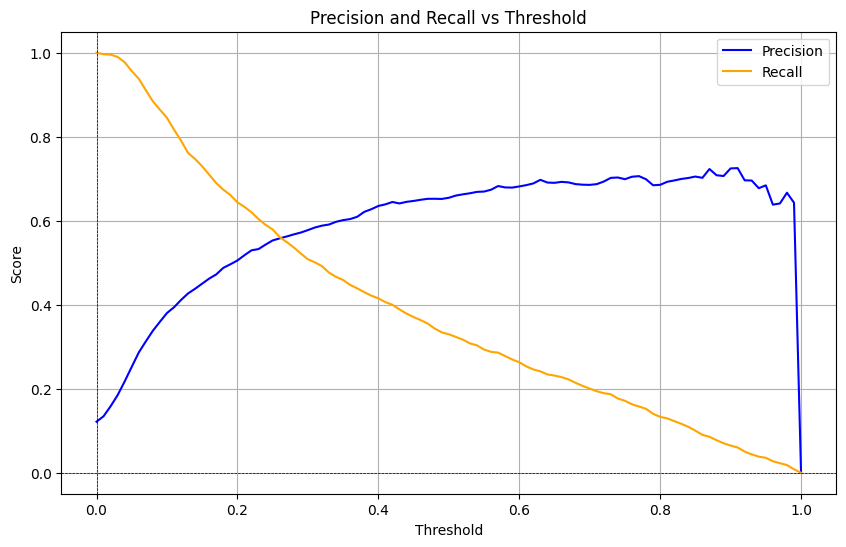

In [28]:
precisions = []
recalls = []
thresholds = np.arange(0.0, 1.01, 0.01)

for threshold in thresholds:
    y_pred_val = (y_pred_val_prob >= threshold).astype(int)
    precisions.append(precision_score(y_val, y_pred_val , zero_division= 0))
    recalls.append(recall_score(y_val, y_pred_val , zero_division= 0))
    
# Plot precision and recall
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='orange')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid()
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.axvline(0, color='black', lw=0.5, ls='--')
plt.show()

In [35]:
intersection_thresholds = []
for i in range(len(thresholds)):
    if np.isclose(precisions[i], recalls[i], atol=0.01):  # Using a tolerance for intersection
        intersection_thresholds.append(thresholds[i])
intersection_thresholds

[0.26, 1.0]

### Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both \
Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 \
At which threshold F1 is maximal?

In [36]:
from sklearn.metrics import f1_score
f1_scores = []
thresholds = np.arange(0.0, 1.01, 0.01)

for threshold in thresholds:
    y_pred_val = (y_pred_val_prob >= threshold).astype(int)       
    f1 = f1_score(y_val, y_pred_val)
    f1_scores.append(f1)

In [43]:
f1_scores = np.array(f1_scores)
best_f1_score = f1_scores.max() 
best_f1_score_threshold = thresholds[f1_scores.argmax()]
best_f1_score, best_f1_score_threshold

(0.5713087248322147, 0.22)

### Question 5

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:\
KFold(n_splits=5, shuffle=True, random_state=1) \
Iterate over different folds of df_full_train \
Split the data into train and validation \
Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000) \
Use AUC to evaluate the model on validation \
How large is standard deviation of the scores across different folds?

In [44]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [45]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical_columns + numerical_columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [49]:
def predict(df, dv, model):
    dicts = df[categorical_columns + numerical_columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [50]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y.values.astype(int)
        y_val = df_val.y.values.astype(int)

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.906 +- 0.006
C=0.01 0.906 +- 0.006
C=0.1 0.906 +- 0.006
C=0.5 0.906 +- 0.006
C=1 0.906 +- 0.006
C=5 0.906 +- 0.006
C=10 0.906 +- 0.006


### Question 6

Now let's use 5-Fold cross-validation to find the best parameter C \
Iterate over the following C values: [0.01, 0.1, 0.5, 10] \
Initialize KFold with the same parameters as previously \
Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000) \
Compute the mean score as well as the std (round the mean and std to 3 decimal digits) 

In [53]:
C_values = [0.01, 0.1, 0.5, 10]
results = {}
for C in tqdm(C_values):
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y.values.astype(int)
        y_val = df_val.y.values.astype(int)

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    # Calculate mean and std
    mean_auc = np.mean(scores)
    std_auc = np.std(scores)

    # Round to 3 decimal digits and store the results
    results[C] = (round(mean_auc, 3), round(std_auc, 3))

  0%|          | 0/4 [00:00<?, ?it/s]

In [54]:
# Print the results
for C, (mean_auc, std_auc) in results.items():
    print(f'C={C} | Mean AUC: {mean_auc} | Std: {std_auc}')

C=0.01 | Mean AUC: 0.906 | Std: 0.006
C=0.1 | Mean AUC: 0.906 | Std: 0.006
C=0.5 | Mean AUC: 0.906 | Std: 0.006
C=10 | Mean AUC: 0.906 | Std: 0.006
